In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

## Get dataset to train

### Simple Data

In [3]:
import numpy as np
import pandas as pd
import time

def generate_clean_vehicle_data(length=100000, seed=42):
    """
    Generates clean synthetic vehicle data without anomalies.

    Parameters:
    - length: Total number of data points.
    - seed: Random seed for reproducibility.

    Returns:
    - data: DataFrame containing the clean vehicle data.
    """
    np.random.seed(seed)

    # Generate synthetic data for speed and battery voltage
    time_values = np.arange(length)
    vehicle_speed = np.clip(60 * np.abs(np.sin(time_values / 500)) + np.random.normal(0, 2, length), 0, 120)
    battery_voltage = np.clip(400 + 5 * np.sin(time_values / 200) + np.random.normal(0, 1, length), 380, 420)

    # Generate timestamps with a 10-second interval
    start_time = int(time.time())
    timestamps = np.arange(start_time, start_time + length * 10, 10)

    # Combine into DataFrame
    data = pd.DataFrame({
        'timestamp': timestamps,
        'vehicle_speed': vehicle_speed,
        'battery_voltage': battery_voltage,
        'anomaly': np.zeros(length)  # No anomalies in the clean training data
    })

    return data

# Example usage
clean_vehicle_data = generate_clean_vehicle_data()
print(clean_vehicle_data.head())

    timestamp  vehicle_speed  battery_voltage  anomaly
0  1718292644       0.993428       401.030595      0.0
1  1718292654       0.000000       398.869645      0.0
2  1718292664       1.535376       400.625436      0.0
3  1718292674       3.406058       399.455759      0.0
4  1718292684       0.011688       399.772591      0.0


In [4]:
clean_vehicle_data

,timestamp,vehicle_speed,battery_voltage,anomaly
0,1718292644,0.993428,401.030595,0.0
1,1718292654,0.000000,398.869645,0.0
2,1718292664,1.535376,400.625436,0.0
3,1718292674,3.406058,399.455759,0.0
4,1718292684,0.011688,399.772591,0.0
...,...,...,...,...
99995,1719292594,52.237076,396.507793,0.0
99996,1719292604,51.490454,398.315642,0.0
99997,1719292614,53.390651,397.887710,0.0
99998,1719292624,52.092160,398.561123,0.0


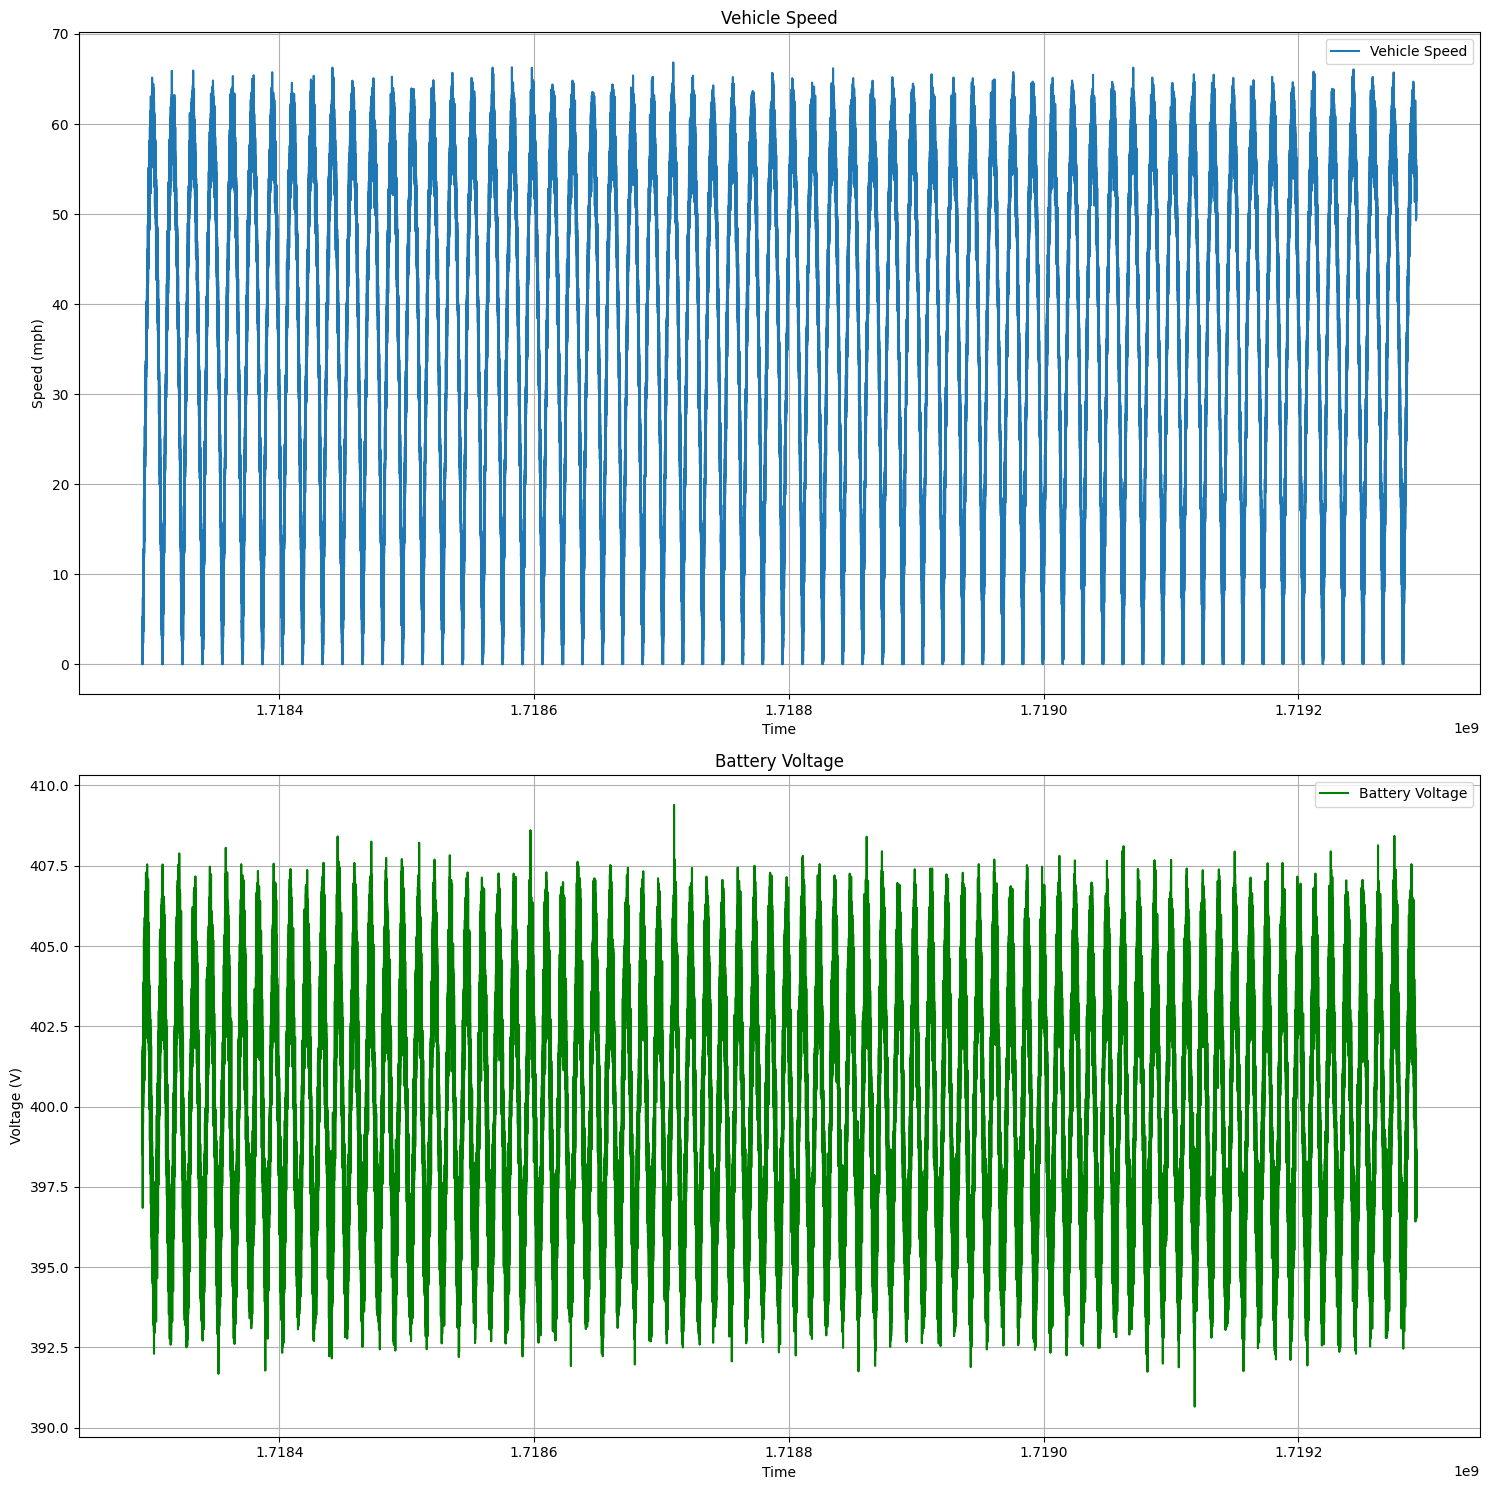

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def visualize_vehicle_data(data):
    """
    Visualizes the vehicle data.

    Parameters:
    - data: DataFrame containing the vehicle data and anomaly labels.
    """
    # Convert epoch timestamps to human-readable datetime
    data['datetime'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

    fig, axs = plt.subplots(2, 1, figsize=(15, 15))

    # Plot vehicle speed
    axs[0].plot(data['timestamp'], data['vehicle_speed'], label='Vehicle Speed')
    axs[0].set_title('Vehicle Speed')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Speed (mph)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot battery voltage
    axs[1].plot(data['timestamp'], data['battery_voltage'], label='Battery Voltage', color='green')
    axs[1].set_title('Battery Voltage')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Voltage (V)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Visualize the data with anomalies
visualize_vehicle_data(clean_vehicle_data)


### Complex Dataset

In [ ]:
import numpy as np
import pandas as pd

def generate_realistic_ev_can_data(length=1000, anomaly_ratio=0.05, seed=42):
    """
    Generates realistic multi-dimensional EV CAN data with anomalies.

    Parameters:
    - length: Total number of data points.
    - anomaly_ratio: Proportion of data points that are anomalies.
    - seed: Random seed for reproducibility.

    Returns:
    - data: DataFrame containing the CAN data and anomaly labels.
    """
    np.random.seed(seed)

    # Time array
    time = np.linspace(0, 50, length)
    
    # Normal data generation
    speed = np.abs(45 * np.sin(time / 5) + np.random.normal(0, 2, length)) + 5  # Speed varies sinusoidally with noise, min 5 mph
    
    battery_soc = np.clip(80 - 0.05 * np.arange(length) + np.random.normal(0, 0.2, length), 0, 100)  # SOC decreases over time
    battery_voltage = np.clip(400 + np.random.normal(0, 5, length), 380, 420)
    battery_current = np.clip(np.random.normal(0, 20, length), -50, 50)  # Positive for discharge, negative for charge
    
    motor_rpm = speed * 30  # Simplified linear relationship for motor RPM
    
    regen_braking = np.clip(np.where(speed > 40, np.random.uniform(0, 30, length), 0), 0, 100)
    brake_pressure = np.clip(np.where(speed > 30, np.random.uniform(0, 20, length), 0), 0, 100)
    
    accelerator_position = np.clip(np.where(speed < 40, np.random.uniform(20, 80, length), np.random.uniform(1, 10)), 0, 100)
    battery_temp = np.clip(25 + 0.01 * np.arange(length) + np.random.normal(0, 1, length), 20, 40)  # Slight increase over time
    motor_temp = np.clip(30 + 0.02 * np.arange(length) + np.random.normal(0, 1, length), 25, 45)  # Slight increase over time

    # Adjusting values based on speed
    motor_rpm[speed < 5] = 0
    regen_braking[speed < 5] = 0
    brake_pressure[speed < 5] = 0
    battery_current[speed < 5] = np.clip(np.random.normal(0, 2, len(battery_current[speed < 5])), -10, 10)  # Limited current draw when stationary

    # Anomaly data generation
    num_anomalies = int(length * anomaly_ratio)
    anomaly_indices = np.random.choice(length, num_anomalies, replace=False)

    for idx in anomaly_indices:
        anomaly_type = np.random.choice(['rapid_discharge', 'increased_braking', 'random_spike'])
        if anomaly_type == 'rapid_discharge':
            battery_soc[idx:] = np.clip(battery_soc[idx:] - np.random.uniform(5, 10), 0, 100)
            battery_voltage[idx:] = np.clip(battery_voltage[idx:] - np.random.uniform(10, 20), 380, 420)
            battery_current[idx] = np.clip(battery_current[idx] + np.random.uniform(50, 100), -50, 50)
        elif anomaly_type == 'increased_braking':
            brake_pressure[idx] = np.clip(brake_pressure[idx] + np.random.uniform(30, 50), 0, 100)
            regen_braking[idx] = np.clip(regen_braking[idx] + np.random.uniform(20, 30), 0, 100)
            speed[idx:] = np.clip(speed[idx:] - np.random.uniform(10, 20), 5, 120)
        elif anomaly_type == 'random_spike':
            speed[idx] += np.random.uniform(20, 40)
            battery_voltage[idx] += np.random.uniform(20, 40)
            battery_current[idx] += np.random.uniform(50, 100)
            motor_rpm[idx] += np.random.uniform(500, 1000)
            battery_temp[idx] += np.random.uniform(5, 10)
            motor_temp[idx] += np.random.uniform(5, 10)

    # Create labels
    labels = np.zeros(length)
    labels[anomaly_indices] = 1

    # Combine into DataFrame
    data = pd.DataFrame({
        'timestamp': np.arange(length),
        'speed': speed,
        'battery_soc': battery_soc,
        'battery_voltage': battery_voltage,
        'battery_current': battery_current,
        'motor_rpm': motor_rpm,
        'regen_braking': regen_braking,
        'brake_pressure': brake_pressure,
        'accelerator_position': accelerator_position,
        'battery_temp': battery_temp,
        'motor_temp': motor_temp,
        'anomaly': labels
    })

    return data

# Example usage
ev_can_data = generate_realistic_ev_can_data(length=100000)
print(ev_can_data.head())

### Normalize data in dataframe

In [6]:
df = clean_vehicle_data.copy()[['vehicle_speed', 'battery_voltage']]

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler() # Can't use this with BCELoss
#scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

/Users/ajay/opt/anaconda3/envs/289a_env/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,vehicle_speed,battery_voltage
0,-2.007890,0.275223
1,-2.061417,-0.313187
2,-1.978689,0.164902
3,-1.877895,-0.153593
4,-2.060787,-0.067322


In [9]:
x = df['vehicle_speed']
y = df['battery_voltage']
print(x.shape)
print(y.shape)

(100000,)
(100000,)


## Create model and dataloaders

In [51]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
# data = window_data(x, 100)
data_x = window_data(x, 100)
data_y = window_data(y, 100)
# print(f"Data shape: {data.shape}")
print(f"Data shape: {data_x.shape}")
print(f"Data shape: {data_y.shape}")

# Create a DataLoader object
#dataloader = DataLoaderGenerator(data, batch_size=32)
dataloader = DataLoaderGenerator(data_y, batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()
print(f"Number of batches: {len(train_loader)}")

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)#, device='cpu')

Data shape: (99901, 100)
Data shape: (99901, 100)
Number of batches: 3121


In [52]:
from torchsummary import summary
if torch.cuda.is_available():
    vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [53]:
train_save = True
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/vehicle_bv_vae.pth")
else:
    # Load the model
    vae.load_model("Weights/vehicle_bv_vae.pth")
    vae.eval()

Epoch 1/10, Loss: 658.963623046875
Epoch 2/10, Loss: 1318.80078125
Epoch 3/10, Loss: 1688.1251220703125
Epoch 4/10, Loss: 2230.34033203125
Epoch 5/10, Loss: 2627.616455078125
Epoch 6/10, Loss: 535.263671875
Epoch 7/10, Loss: 3137.27490234375
Epoch 8/10, Loss: 879.8695068359375
Epoch 9/10, Loss: 830.9005737304688
Epoch 10/10, Loss: 2607.60400390625


### Loss Analysis

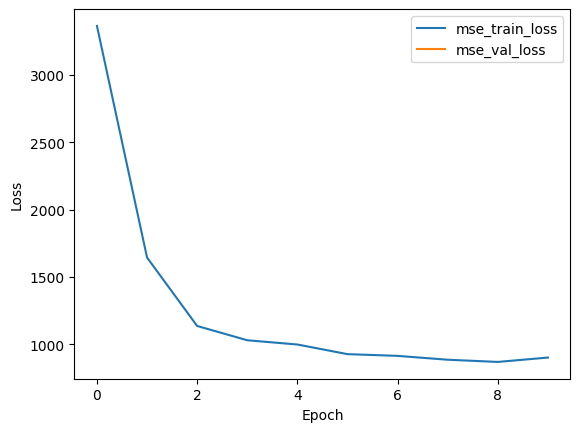

In [54]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [55]:
encoded_training_data = vae.encode_data(train_loader)

In [56]:
print(encoded_training_data.shape)

(99872, 6)


In [57]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [58]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([99872, 1, 6])

In [59]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
if torch.cuda.is_available():
    lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
│    └─Linear: 2-4                       [1, 6]                    42
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22

## Train LSTM

In [61]:
train_save = True
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/vehicle_bv_lstm.pth")
else:
    # Load the model
    lstm.load_model("Weights/vehicle_bv_lstm.pth")
    lstm.eval()

Epoch 1/10, Loss: 0.5371748208999634
Epoch 2/10, Loss: 0.10770097374916077
Epoch 3/10, Loss: 0.06522531062364578
Epoch 4/10, Loss: 0.06501762568950653
Epoch 5/10, Loss: 0.041138093918561935
Epoch 6/10, Loss: 0.02132584899663925
Epoch 7/10, Loss: 0.014417583122849464
Epoch 8/10, Loss: 0.01291509997099638
Epoch 9/10, Loss: 0.010401557199656963
Epoch 10/10, Loss: 0.011252281256020069


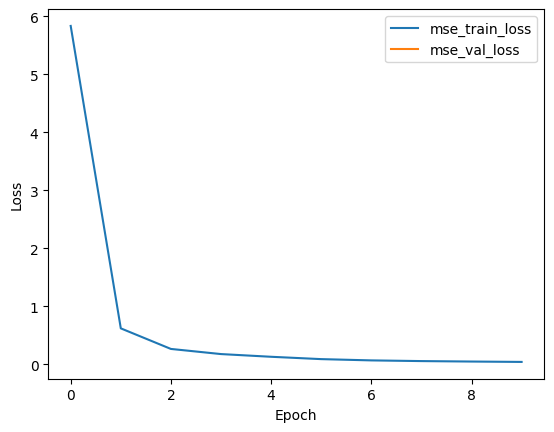

In [62]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [63]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)

In [64]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import time

def generate_normalized_test_data_with_anomalies(length=100000, column='vehicle_speed', anomaly_ratio=0.00005, seed=None):
    """
    Generates normalized test data with anomalies for vehicle speed or battery voltage and returns two arrays:
    one with the test data including anomalies and the second indicating whether an index has an anomaly or not.

    Parameters:
    - length: Total number of data points.
    - column: Column name to introduce anomalies into ('vehicle_speed' or 'battery_voltage').
    - anomaly_ratio: Proportion of data points that are anomalies.
    - seed: Random seed for reproducibility. Default is None.

    Returns:
    - test_data: np.ndarray containing the normalized test data including anomalies.
    - anomaly_labels: np.ndarray of booleans indicating whether each index has an anomaly or not.
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate synthetic data for speed and battery voltage
    time_values = np.arange(length)
    vehicle_speed = np.clip(60 * np.abs(np.sin(time_values / 500)) + np.random.normal(0, 2, length), 0, 120)
    battery_voltage = np.clip(400 + 5 * np.sin(time_values / 200) + np.random.normal(0, 1, length), 380, 420)

    # Select the column to introduce anomalies
    if column == 'vehicle_speed':
        data = vehicle_speed
    elif column == 'battery_voltage':
        data = battery_voltage
    else:
        raise ValueError("Invalid column name. Choose 'vehicle_speed' or 'battery_voltage'.")

    # Anomaly data generation
    num_anomalies = int(length * anomaly_ratio)
    anomaly_indices = np.random.choice(length, num_anomalies, replace=False)
    
    for idx in anomaly_indices:
        if column == 'battery_voltage':
            data[idx:] = np.clip(data[idx:] - np.random.uniform(5, 10), 380, 420)
        elif column == 'vehicle_speed':
            data[idx] += np.random.uniform(20, 40)

    # Create anomaly labels
    anomaly_labels = np.zeros(length, dtype=bool)
    anomaly_labels[anomaly_indices] = True

    # Normalize the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    return data, anomaly_labels

# Example usage
test_data_speed, anomaly_labels_speed = generate_normalized_test_data_with_anomalies(column='vehicle_speed', seed=42)
test_data_voltage, anomaly_labels_voltage = generate_normalized_test_data_with_anomalies(column='battery_voltage', seed=43)

print(test_data_speed[:10])
print(anomaly_labels_speed[:10])
print(test_data_voltage[:10])
print(anomaly_labels_voltage[:10])

[0.01096727 0.         0.01695028 0.03760225 0.00012903 0.00145412
 0.04281692 0.02621782 0.00023195 0.02390189]
[False False False False False False False False False False]
[0.77678629 0.71435687 0.76766451 0.68436532 0.73041827 0.7270293
 0.7525681  0.77621038 0.75691465 0.7709781 ]
[False False False False False False False False False False]


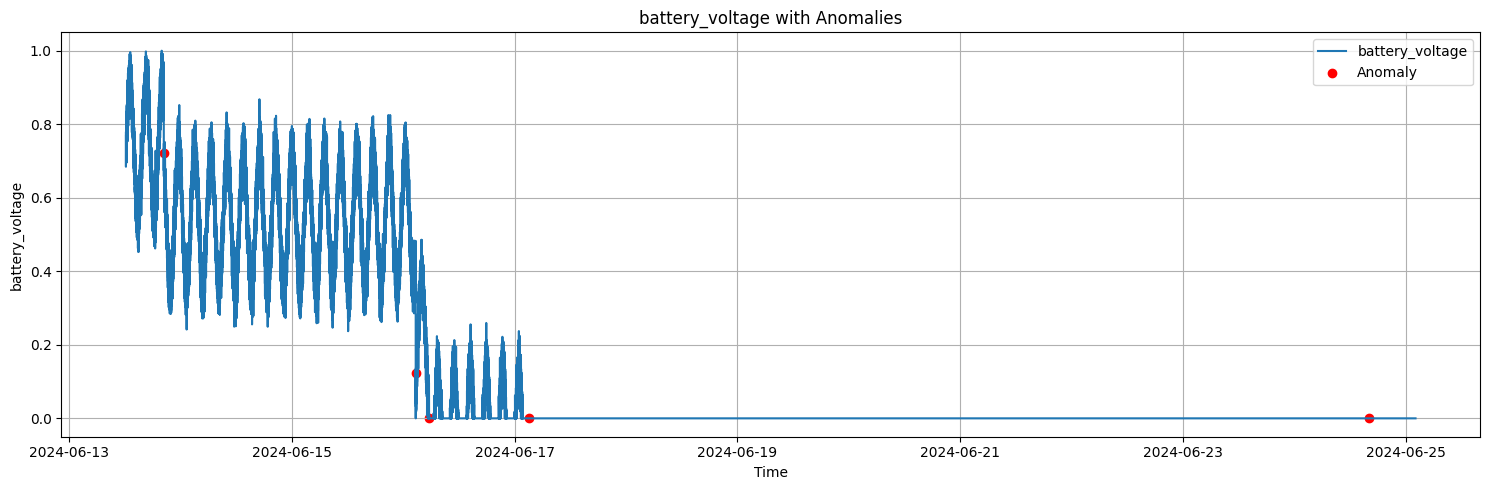

In [65]:
import matplotlib.pyplot as plt
from datetime import datetime

def visualize_test_data_with_anomalies(timestamps, test_data, anomaly_labels, column_name):
    """
    Visualizes the test data with anomalies.

    Parameters:
    - timestamps: Array of timestamps.
    - test_data: np.ndarray containing the test data including anomalies.
    - anomaly_labels: np.ndarray of booleans indicating whether each index has an anomaly or not.
    - column_name: Name of the column ('vehicle_speed' or 'battery_voltage').
    """
    # Convert epoch timestamps to human-readable datetime
    datetime_labels = [datetime.fromtimestamp(ts) for ts in timestamps]

    fig, ax = plt.subplots(figsize=(15, 5))

    # Plot test data
    ax.plot(datetime_labels, test_data, label=column_name)

    # Highlight anomalies
    anomaly_indices = np.where(anomaly_labels)[0]
    ax.scatter([datetime_labels[i] for i in anomaly_indices], test_data[anomaly_indices], color='red', label='Anomaly')

    ax.set_title(f'{column_name} with Anomalies')
    ax.set_xlabel('Time')
    ax.set_ylabel(column_name)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Generate timestamps with a 10-second interval
length = 100000
start_time = int(time.time())
timestamps = np.arange(start_time, start_time + length * 10, 10)

# Visualize the test data with anomalies for vehicle speed
visualize_test_data_with_anomalies(timestamps, test_data_voltage, anomaly_labels_voltage, 'battery_voltage')

In [67]:
import numpy as np

if isinstance(anomaly_labels_voltage, np.ndarray) and anomaly_labels_speed.dtype == bool:
    print("anomalies is a numpy array of booleans")
else:
    print("anomalies is not a numpy array of booleans")

anomalies is a numpy array of booleans


Threshold: 0.1, Precision: 4.017677782241864e-05, Recall: 0.6, F1 Score: 8.034817542684968e-05
	Augmented Precision: 6.695950289265053e-05, Augmented Recall: 1.0, Augmented F1 Score: 0.0001339100392356415
Threshold: 0.125, Precision: 4.0224722114211397e-05, Recall: 0.6, F1 Score: 8.044405116241655e-05
	Augmented Precision: 6.703940576270732e-05, Augmented Recall: 1.0, Augmented F1 Score: 0.0001340698235641122
Threshold: 0.15000000000000002, Precision: 4.027061855670103e-05, Recall: 0.6, F1 Score: 8.053583173380223e-05
	Augmented Precision: 6.71158957287444e-05, Augmented Recall: 1.0, Augmented F1 Score: 0.0001342227829751822
Threshold: 0.17500000000000002, Precision: 4.03171616718183e-05, Recall: 0.6, F1 Score: 8.062890546260834e-05
	Augmented Precision: 6.719346341987851e-05, Augmented Recall: 1.0, Augmented F1 Score: 0.00013437789752341535
Threshold: 0.2, Precision: 4.036381249663635e-05, Recall: 0.6, F1 Score: 8.072219456739631e-05
	Augmented Precision: 6.727121061270619e-05, Augmen

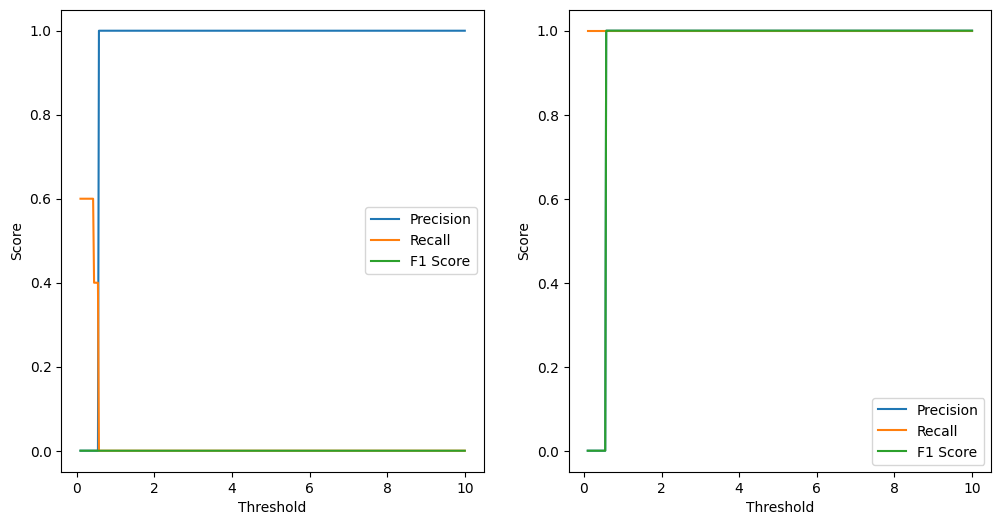

Best threshold: 0.42500000000000004
Best precision: 4.0829102984607426e-05
Best recall: 0.6
Best F1: 8.165264962848043e-05
Best threshold (augmented): 0.5750000000000001
Best precision (augmented): 1.0
Best recall (augmented): 1.0
Best F1 (augmented): 1.0


In [68]:
best_threshold, best_precision, best_recall, best_f1, best_threshold_aug, best_precision_aug, best_recall_aug, best_f1_aug = \
    vae_lstm.evaluate(test_data_voltage, anomaly_labels_voltage, plot=True, threshold_option=1)

print(f"Best threshold: {best_threshold}")
print(f"Best precision: {best_precision}")
print(f"Best recall: {best_recall}")
print(f"Best F1: {best_f1}")
print(f"Best threshold (augmented): {best_threshold_aug}")
print(f"Best precision (augmented): {best_precision_aug}")
print(f"Best recall (augmented): {best_recall_aug}")
print(f"Best F1 (augmented): {best_f1_aug}")

In [ ]:
vae_lstm.plot_anomaly(test_data_speed, best_threshold, None)

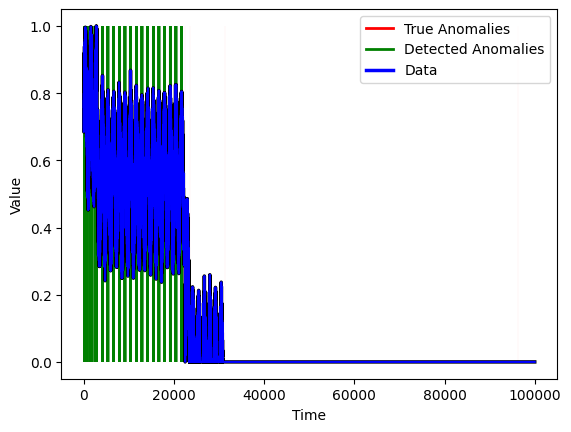

In [69]:
vae_lstm.plot_anomaly(test_data_voltage, best_threshold, anomaly_labels_voltage)